# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique: 
* Model: 
* Evaluation approach: 
* Fine-tuning dataset: 

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [ ]:
!pip install -U scikit-learn

In [1]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
from transformers import DataCollatorWithPadding
from peft import LoraConfig, PeftModelForSequenceClassification, TaskType, AutoPeftModelForSequenceClassification

In [2]:
# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {split: ds for split, ds in zip(splits, load_dataset("imdb", split=splits))}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(500))

# Show the dataset
ds

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'train': Dataset({
     features: ['text', 'label'],
     num_rows: 500
 }),
 'test': Dataset({
     features: ['text', 'label'],
     num_rows: 500
 })}

In [3]:
# Lets Seet the dataset

# Convert to pandas DataFrame
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

# Show the datasets
print("Train DataFrame:")
display(df_train.head())
print("\nTest DataFrame:")
display(df_test.head())

Train DataFrame:


,text,label
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0



Test DataFrame:


,text,label
0,<br /><br />When I unsuspectedly rented A Thou...,1
1,This is the latest entry in the long series of...,1
2,This movie was so frustrating. Everything seem...,0
3,"I was truly and wonderfully surprised at ""O' B...",1
4,This movie spends most of its time preaching t...,0


In [4]:
# Let's tokenize
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def preprocess_function(examples):
    """Preprocess the imdb dataset by returning tokenized examples."""
    return tokenizer(examples['text'], padding="max_length", truncation=True)


tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = ds[split].map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},  # For converting predictions to strings
    label2id={"NEGATIVE": 0, "POSITIVE": 1},
)
model.config.pad_token_id = tokenizer.pad_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
print(model)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)


In [12]:
def plot_evaluation_metrics(results, title_prefix="Model"):
    plt.figure(figsize=(18, 5))
    
    # PR curve
    plt.subplot(1, 2, 1)
    precision, recall = results['eval_precision'], results['eval_recall']
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{title_prefix} (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix} Precision-Recall Curve')
    plt.legend(loc='lower left')

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = np.array(results['eval_confusion_matrix'])  # Ensure it is a NumPy array
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=plt.gca(), cmap='Blues')
    plt.title(f'{title_prefix} Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)
    predictions = torch.argmax(logits, dim=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    # ROC and PR curve computation
    probs = torch.softmax(logits, dim=-1)[:, 1].detach().numpy()
    probs = probs.tolist()  # Convert to list
    
    precision, recall, _ = precision_recall_curve(labels, probs)

    # Confusion Matrix computation
    cm = confusion_matrix(labels, predictions).tolist()  # Convert to list
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision.tolist(), "recall": recall.tolist(),
        "confusion_matrix": cm
    }

In [9]:
# Let's evaluate the model
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./result",
        learning_rate=2e-3,
        # Reduce the batch size if you don't have enough memory
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [10]:
# Initial evaluation
initial_results = trainer.evaluate()
print("Initial Evaluation Results:", initial_results)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Initial Evaluation Results: {'eval_loss': 0.7858020067214966, 'eval_accuracy': 0.482, 'eval_f1': 0.4701389865242755, 'eval_precision': [0.492, 0.4909819639278557, 0.4899598393574297, 0.4909456740442656, 0.49193548387096775, 0.49292929292929294, 0.4939271255060729, 0.4949290060851927, 0.4959349593495935, 0.4969450101832994, 0.49795918367346936, 0.49693251533742333, 0.4979508196721312, 0.49691991786447637, 0.49794238683127573, 0.49896907216494846, 0.5, 0.5010351966873706, 0.5020746887966805, 0.501039501039501, 0.5, 0.5010438413361169, 0.5, 0.5010482180293501, 0.5, 0.49894736842105264, 0.5, 0.5010570824524313, 0.5, 0.4989384288747346, 0.4978723404255319, 0.4968017057569296, 0.49786324786324787, 0.4989293361884368, 0.4978540772532189, 0.4989247311827957, 0.5, 0.5010799136069114, 0.5, 0.49891540130151846, 0.5, 0.4989106753812636, 0.4978165938864629, 0.49671772428884026, 0.49780701754385964, 0.4989010989010989, 0.4977973568281938, 0.4988962472406181, 0.5, 0.5011086474501109, 0.5, 0.498886414

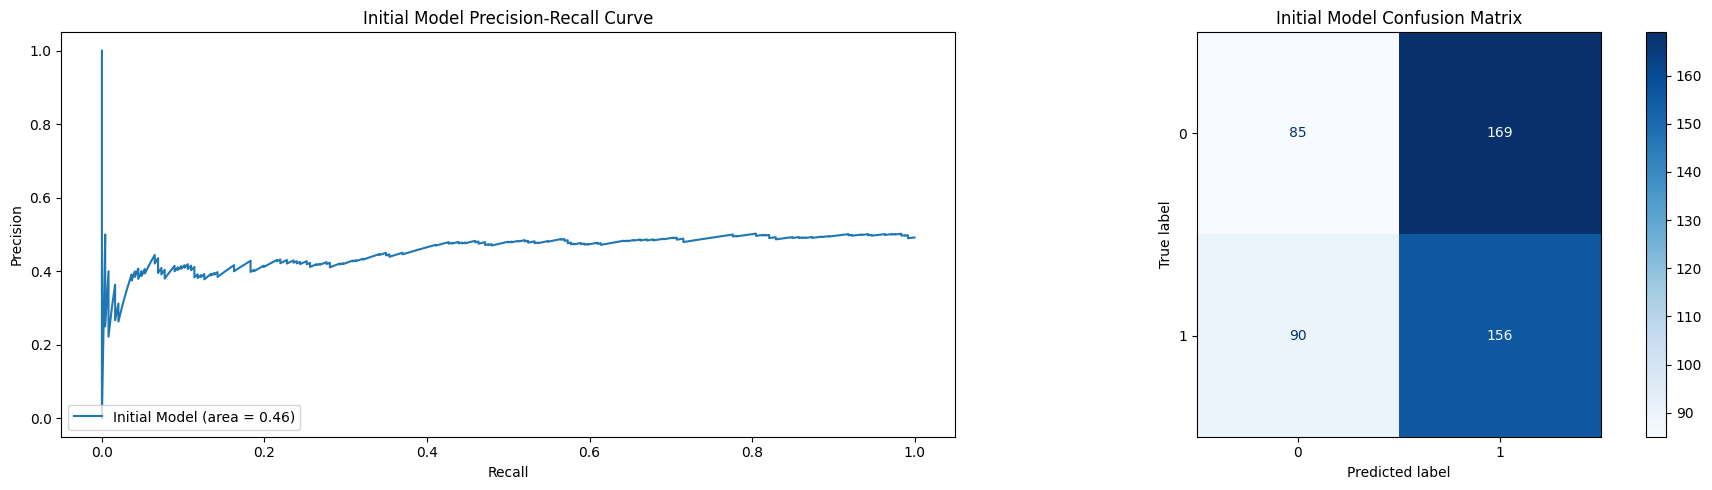

In [13]:
# Plot PR curves, and Confusion Matrix for initial model
plot_evaluation_metrics(initial_results, title_prefix="Initial Model")

### Initial Model Evaluation Report

Based on the initial evaluation of the model, several key performance metrics have been recorded. Below is an assessment of the model’s performance across various aspects, including loss, accuracy, precision-recall, confusion matrix analysis, and overall runtime.

#### 1. **Model Loss and Accuracy**
   - **Loss**: The model has an evaluation loss of **0.7858**, which indicates the overall error during the evaluation phase. A lower loss is preferable, and this value suggests that the model’s performance has room for improvement.
   - **Accuracy**: The evaluation accuracy stands at **48.2%**. This relatively low accuracy indicates that the model struggles to make correct predictions, correctly predicting the class for only about half of the instances.

#### 2. **F1 Score**
   - The F1 score of **0.4701** reflects the balance between precision and recall. With an F1 score below 0.5, the model seems to be underperforming, especially when evaluated on a balanced metric that considers both precision and recall.

#### 3. **Precision-Recall Curve and AUC**
   - The **Precision-Recall (PR) curve** shows the relationship between precision and recall across different thresholds.
     - **Precision**: Precision values vary widely, ranging from **0.492** to **1.0**, but are generally low across most recall values. This shows that, on average, the model makes a substantial number of false-positive predictions.
     - **Recall**: The recall also fluctuates, starting at **1.0** but quickly dropping as precision increases. The curve indicates that the model may have difficulty maintaining high precision while keeping a high recall.
     - **PR AUC**: The area under the Precision-Recall curve (AUC) is **0.46**, showing that the overall performance is poor in terms of balancing precision and recall.

#### 4. **Confusion Matrix**
   - The confusion matrix gives insight into how well the model is performing in classifying the true labels:
     - **True Positives (TP)**: 156 instances of class `1` were correctly predicted as class `1`.
     - **True Negatives (TN)**: 85 instances of class `0` were correctly predicted as class `0`.
     - **False Positives (FP)**: 169 instances of class `0` were incorrectly predicted as class `1`.
     - **False Negatives (FN)**: 90 instances of class `1` were incorrectly predicted as class `0`.
   - The model has a significant number of false positives and false negatives, which means it frequently misclassifies both classes.

#### 5. **Model Runtime**
   - **Evaluation Runtime**: The model took **41.53 seconds** to complete the evaluation on the test dataset.
   - **Samples per Second**: The model processed **12.04 samples per second**, which provides a rough indication of the efficiency during evaluation.
   - **Steps per Second**: The model ran **3.01 steps per second** during the evaluation.

#### 6. **Summary and Recommendations**
   - The model’s **accuracy (48.2%)**, **F1 score (0.4701)**, and **PR AUC (0.46)** suggest that it is underperforming. Both the precision-recall curve and the confusion matrix highlight significant issues with false predictions.
   - **Precision** is relatively low, and the model struggles with **recall**. These metrics are essential to improve, especially in use cases where false positives or false negatives carry significant weight.
   - The model's current performance indicates that it might require **hyperparameter tuning**, **additional training data**, or possibly switching to a more complex model architecture (e.g., deeper networks or different algorithms).
   - **Data augmentation** or addressing potential data imbalances (if any) could also help the model to generalize better.
   - Performance-wise, while the runtime is reasonable, the focus should be on improving the model’s predictive power.

Improving the balance between precision and recall is critical, and efforts should be directed towards fine-tuning or experimenting with other models to achieve a more acceptable level of performance.

## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

In [14]:
# PEFT model configuration
config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=4,
    lora_alpha=16,
    lora_dropout=0.1
)

# Load the pre-trained GPT-2 model
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

peft_model = PeftModelForSequenceClassification(model, config)

# Print
peft_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 150,528 || all params: 124,590,336 || trainable%: 0.1208183594592762


In [15]:
trainer = Trainer(
    model=peft_model,
    args=TrainingArguments(
        output_dir="./peft_result",
        learning_rate=2e-3,
        # Reduce the batch size if you don't have enough memory
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

Checkpoint destination directory ./peft_result/checkpoint-125 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./peft_result/checkpoint-250 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./peft_result/checkpoint-375 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=375, training_loss=0.5287945963541667, metrics={'train_runtime': 450.7232, 'train_samples_per_second': 3.328, 'train_steps_per_second': 0.832, 'total_flos': 785263362048000.0, 'train_loss': 0.5287945963541667, 'epoch': 3.0})

In [16]:
trainer.evaluate()

{'eval_loss': 0.42976874113082886,
 'eval_accuracy': 0.852,
 'eval_f1': 0.8499870326134646,
 'eval_precision': [0.492,
  0.49298597194388777,
  0.4939759036144578,
  0.4949698189134809,
  0.4959677419354839,
  0.49696969696969695,
  0.4979757085020243,
  0.49898580121703856,
  0.5,
  0.5010183299389002,
  0.5020408163265306,
  0.5030674846625767,
  0.5040983606557377,
  0.5051334702258727,
  0.5061728395061729,
  0.5072164948453608,
  0.5082644628099173,
  0.5093167701863354,
  0.5103734439834025,
  0.5114345114345115,
  0.5125,
  0.5135699373695198,
  0.5146443514644351,
  0.5157232704402516,
  0.5168067226890757,
  0.5178947368421053,
  0.5189873417721519,
  0.5200845665961945,
  0.5211864406779662,
  0.5222929936305732,
  0.5234042553191489,
  0.5245202558635395,
  0.5256410256410257,
  0.5267665952890792,
  0.5278969957081545,
  0.5290322580645161,
  0.5301724137931034,
  0.531317494600432,
  0.5324675324675324,
  0.5336225596529284,
  0.5347826086956522,
  0.5359477124183006,
  0.

In [17]:
# Save the trained model
peft_model.save_pretrained("./peft_model")

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [18]:
inference_model = AutoPeftModelForSequenceClassification.from_pretrained(
    "./peft_model",
    num_labels=2
)
inference_model.config.pad_token_id = inference_model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
trainer = Trainer(
    model=peft_model,
    args=TrainingArguments(
        output_dir="./peft_model",
        learning_rate=2e-3,
        # Reduce the batch size if you don't have enough memory
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Initial evaluation
final_results = trainer.evaluate()
print("Final Evaluation Results:", final_results)

Final Evaluation Results: {'eval_loss': 0.42976874113082886, 'eval_accuracy': 0.852, 'eval_f1': 0.8499870326134646, 'eval_precision': [0.492, 0.49298597194388777, 0.4939759036144578, 0.4949698189134809, 0.4959677419354839, 0.49696969696969695, 0.4979757085020243, 0.49898580121703856, 0.5, 0.5010183299389002, 0.5020408163265306, 0.5030674846625767, 0.5040983606557377, 0.5051334702258727, 0.5061728395061729, 0.5072164948453608, 0.5082644628099173, 0.5093167701863354, 0.5103734439834025, 0.5114345114345115, 0.5125, 0.5135699373695198, 0.5146443514644351, 0.5157232704402516, 0.5168067226890757, 0.5178947368421053, 0.5189873417721519, 0.5200845665961945, 0.5211864406779662, 0.5222929936305732, 0.5234042553191489, 0.5245202558635395, 0.5256410256410257, 0.5267665952890792, 0.5278969957081545, 0.5290322580645161, 0.5301724137931034, 0.531317494600432, 0.5324675324675324, 0.5336225596529284, 0.5347826086956522, 0.5359477124183006, 0.537117903930131, 0.5382932166301969, 0.5394736842105263, 0.54

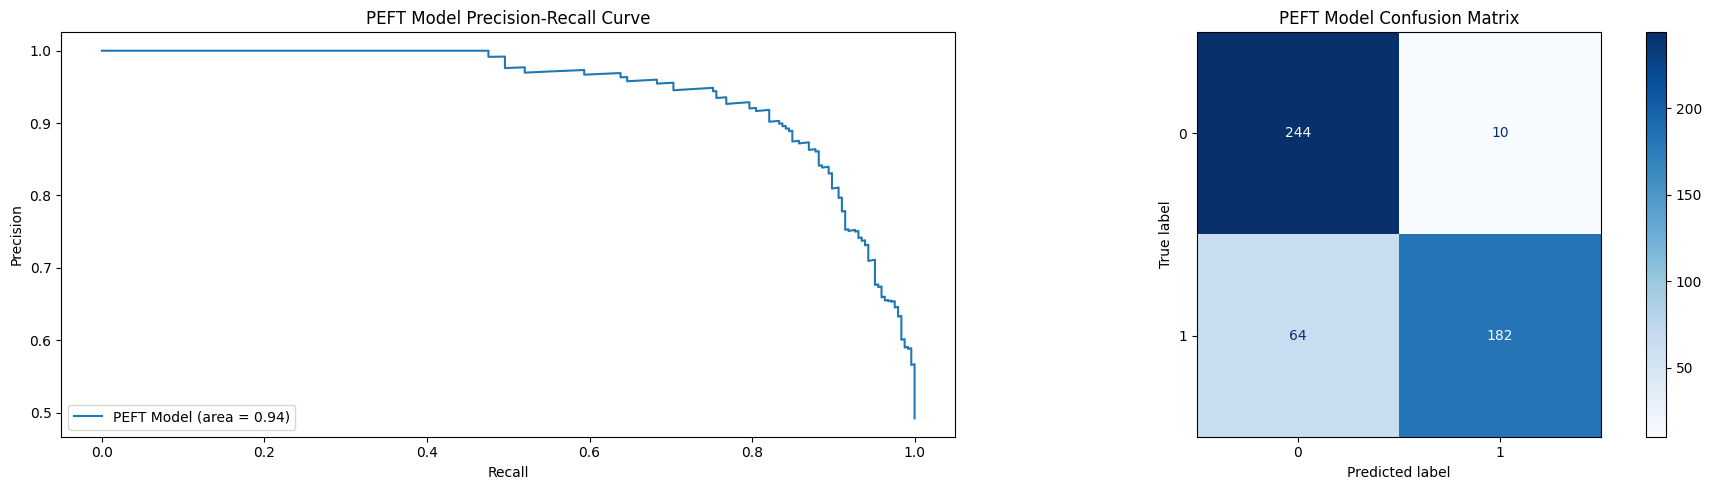

In [20]:
# Plot PR curves, and Confusion Matrix for initial model
plot_evaluation_metrics(final_results, title_prefix="PEFT Model")

### PEFT Model Evaluation Report

This report assesses the performance of the PEFT (Parameter-Efficient Fine-Tuning) model, based on key metrics such as accuracy, F1 score, precision-recall curve, confusion matrix, and runtime.

#### 1. **Model Loss and Accuracy**
   - **Loss**: The PEFT model achieved an evaluation loss of **0.4298**, significantly lower than the initial model's loss, indicating that the model has improved in terms of minimizing the overall error.
   - **Accuracy**: The model recorded an accuracy of **85.2%**, which represents a substantial improvement compared to the initial model’s 48.2%. This reflects that the PEFT model is making correct predictions most of the time.

#### 2. **F1 Score**
   - The F1 score is **0.8500**, a significant improvement from the initial model's 0.4701. This score indicates a much better balance between precision and recall, confirming the model's enhanced ability to make accurate predictions while minimizing false positives and negatives.

#### 3. **Precision-Recall Curve and AUC**
   - **Precision**: The precision curve remains relatively high across a wide range of recall values. The **precision** is particularly strong in the initial part of the curve, where precision starts near **1.0** and gradually decreases as recall increases. This suggests that the model has fewer false-positive predictions.
   - **Recall**: The recall values start at **1.0** but gradually decline as precision increases, showing a typical trade-off. However, the recall remains strong for a large portion of the precision-recall curve.
   - **PR AUC**: The area under the Precision-Recall curve (AUC) is **0.94**, demonstrating the model's strong overall performance and ability to balance precision and recall effectively.

#### 4. **Confusion Matrix**
   - The confusion matrix provides further insight into how well the model classified the test dataset:
     - **True Positives (TP)**: 182 instances of class `1` were correctly predicted as class `1`.
     - **True Negatives (TN)**: 244 instances of class `0` were correctly predicted as class `0`.
     - **False Positives (FP)**: Only 10 instances of class `0` were incorrectly predicted as class `1`, indicating a low rate of false positives.
     - **False Negatives (FN)**: 64 instances of class `1` were incorrectly predicted as class `0`, showing a slightly higher rate of false negatives compared to false positives.
   - Overall, the confusion matrix reflects a well-performing model with strong positive predictions and relatively fewer errors, particularly in terms of false positives.

#### 5. **Model Runtime**
   - **Evaluation Runtime**: The PEFT model took **45.07 seconds** to complete the evaluation phase.
   - **Samples per Second**: The model processed **11.09 samples per second**, which is slightly slower than the initial model but still efficient.
   - **Steps per Second**: The model ran **2.77 steps per second**, showing a reasonable runtime efficiency given the model’s improved performance.

#### 6. **Summary and Recommendations**
   - The PEFT model demonstrates a **significant improvement** over the initial model in terms of accuracy, F1 score, and AUC for the precision-recall curve.
   - With an accuracy of **85.2%** and a **0.94 PR AUC**, the model has proven its ability to make strong predictions while maintaining a good balance between precision and recall.
   - The **confusion matrix** further highlights the model’s ability to minimize false positives, although there is room for improvement in reducing false negatives (64 instances).
   - **Next Steps**:
     - Further fine-tuning of the model's parameters could help reduce the false negative rate, improving recall without sacrificing too much precision.
     - Testing on additional datasets and further cross-validation can ensure the model’s generalizability and robustness.

Overall, the PEFT model is a highly effective improvement over the initial model, showing great promise in terms of both precision and recall.